### Train/test split

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

In [2]:
# Load the dataset
df = pd.read_csv('diabetic_data_cleaned.csv')

In [3]:
# Features and target variable
X = df.drop(columns=['readmitted', 'patient_nbr'], axis=1)
y = df['readmitted']

# Train-Test Split (stratified to preserve imbalance ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Baseline Model

In [4]:
# Identify column types
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipelines (OneHot for categorical, Scaling for numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [5]:
# Logistic Regression (with class_weight to handle imbalance)
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

log_reg.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [6]:
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_lr))

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.92      0.66      0.77     17469
           1       0.17      0.55      0.26      2250

    accuracy                           0.65     19719
   macro avg       0.55      0.61      0.52     19719
weighted avg       0.83      0.65      0.71     19719

ROC-AUC: 0.6509868020175422


In [7]:
# Random Forest Pipeline (no scaling needed, but keep preprocessor for encoding)
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42))
])

rf_clf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [8]:
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_rf))

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17469
           1       0.62      0.00      0.00      2250

    accuracy                           0.89     19719
   macro avg       0.76      0.50      0.47     19719
weighted avg       0.86      0.89      0.83     19719

ROC-AUC: 0.6445977572970532


🔎

- Logistic Regression at least detects readmissions (though imprecisely).

- Random Forest, despite higher accuracy, ignores the minority class.

- Both models are struggling because of class imbalance.

### Resampling (using SMOTE)

In [9]:
# Logistic regression with SMOTE
log_reg_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

log_reg_smote.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
y_pred_smote_lr = log_reg_smote.predict(X_test)
y_proba_smote_lr = log_reg_smote.predict_proba(X_test)[:, 1]

print("=== Logistic Regression with SMOTE ===")
print(classification_report(y_test, y_pred_smote_lr))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_smote_lr))

=== Logistic Regression with SMOTE ===
              precision    recall  f1-score   support

           0       0.92      0.65      0.76     17469
           1       0.17      0.54      0.26      2250

    accuracy                           0.64     19719
   macro avg       0.54      0.60      0.51     19719
weighted avg       0.83      0.64      0.71     19719

ROC-AUC: 0.6364401956481641


In [11]:
# Random Forest with SMOTE
rf_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_smote.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
y_pred_smote_rf = rf_smote.predict(X_test)
y_proba_smote_rf = rf_smote.predict_proba(X_test)[:, 1]

print("=== Random Forest with SMOTE ===")
print(classification_report(y_test, y_pred_smote_rf))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_smote_rf))

=== Random Forest with SMOTE ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17469
           1       0.35      0.01      0.01      2250

    accuracy                           0.89     19719
   macro avg       0.62      0.50      0.48     19719
weighted avg       0.83      0.89      0.83     19719

ROC-AUC: 0.6430833158420313


🔎

Logistic Regression
- Same pattern as before: model does catch some readmissions (~54%), but it generates lots of false positives (low precision).
- SMOTE didn’t improve performance here — Logistic Regression is still too simple for the complexity of the data.

Random Forest
- It almost never predicts readmission (recall is basically zero)
- Even with SMOTE, RF is biased toward the majority class.

### XGBoost Pipeline

In [13]:
# Compute scale_pos_weight for XGBoost
scale_pos_weight = (y_train.value_counts()[0]) / (y_train.value_counts()[1])

In [14]:
# XGBoost Pipeline
xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

# Fit the XGBoost model
xgb_pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:07:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.92      0.71      0.80     17469
           1       0.18      0.50      0.27      2250

    accuracy                           0.69     19719
   macro avg       0.55      0.61      0.53     19719
weighted avg       0.83      0.69      0.74     19719

ROC-AUC: 0.647145419505028


🔎

Class 0 (not readmitted):

- Precision = 0.92, Recall = 0.71 → it’s still very strong at catching non-readmissions.

Class 1 (readmitted):

- Precision = 0.18 → lots of false positives.

- Recall = 0.50 → catches half of true readmissions, which is much better than Random Forest (0%) and on par with Logistic Regression.

ROC-AUC = 0.65 → about the same as Logistic Regression & Random Forest, but the recall improvement for class 1 makes XGBoost more useful.

### Threshold Tuning + PR Curve

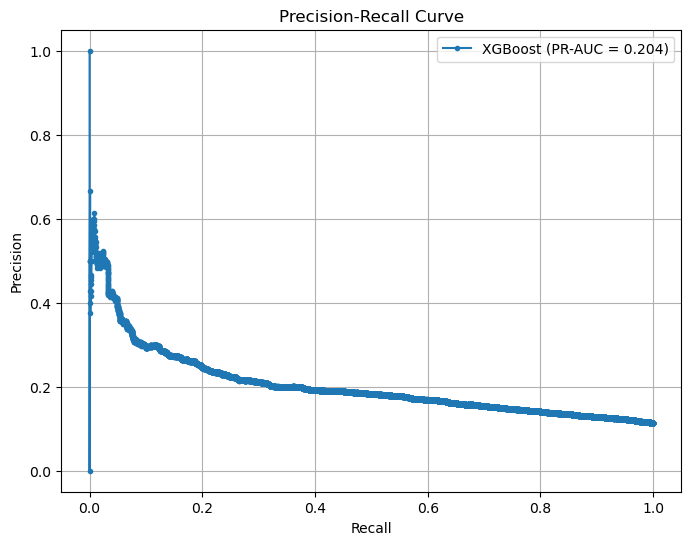

In [16]:
# Precision-Recall Curve for XGBoost
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)
pr_auc = average_precision_score(y_test, y_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label=f'XGBoost (PR-AUC = {pr_auc:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

📌 PR-AUC (0.204) shows the task is quite imbalanced and hard — typical in healthcare prediction problems

In [17]:
# Threshold Tuning
# Find threshold that gives ~70% recall
target_recall = 0.7
idx = np.argmin(np.abs(recall - target_recall))
best_thresh = thresholds[idx]

print(f"Best threshold for ~{target_recall*100}% recall: {best_thresh:.3f}")

Best threshold for ~70.0% recall: 0.398


In [18]:
# Apply new threshold
y_pred_thresh = (y_proba_xgb >= best_thresh).astype(int)

print("=== XGBoost with Tuned Threshold ===")
print(classification_report(y_test, y_pred_thresh))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

=== XGBoost with Tuned Threshold ===
              precision    recall  f1-score   support

           0       0.93      0.51      0.66     17469
           1       0.15      0.70      0.25      2250

    accuracy                           0.53     19719
   macro avg       0.54      0.60      0.45     19719
weighted avg       0.84      0.53      0.61     19719

ROC-AUC: 0.647145419505028


🔍

In hospital readmission prediction, recall is often more important than precision:

- Missing a readmission (false negative) → could be costly in patient outcomes and penalties.

- False positives → extra monitoring or intervention, but less harmful.

With threshold tuning, I’ve made the model more sensitive to possible readmissions.

### Get Feature Importances

In [19]:
# Extract the trained model and feature names 
# Get the fitted preprocessor and model
fitted_preprocessor = xgb_pipeline.named_steps['preprocessor']
fitted_model = xgb_pipeline.named_steps['model']

# For ColumnTransformer, use get_feature_names_out 
feature_names = fitted_preprocessor.get_feature_names_out()

# Get feature importances from XGBoost 
importances = fitted_model.feature_importances_

# Pair feature names with their importances
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

                                 Feature  Importance
6                  num__number_inpatient    0.035309
30       cat__discharge_disposition_Home    0.031257
34   cat__discharge_disposition_Transfer    0.019719
139                 cat__diabetesMed_Yes    0.016620
32    cat__discharge_disposition_Hospice    0.014616
45           cat__diag_1_Musculoskeletal    0.013622
55                 cat__diag_2_Neoplasms    0.011930
5                  num__number_emergency    0.011171
138                  cat__diabetesMed_No    0.011047
40               cat__diag_1_Circulatory    0.010739


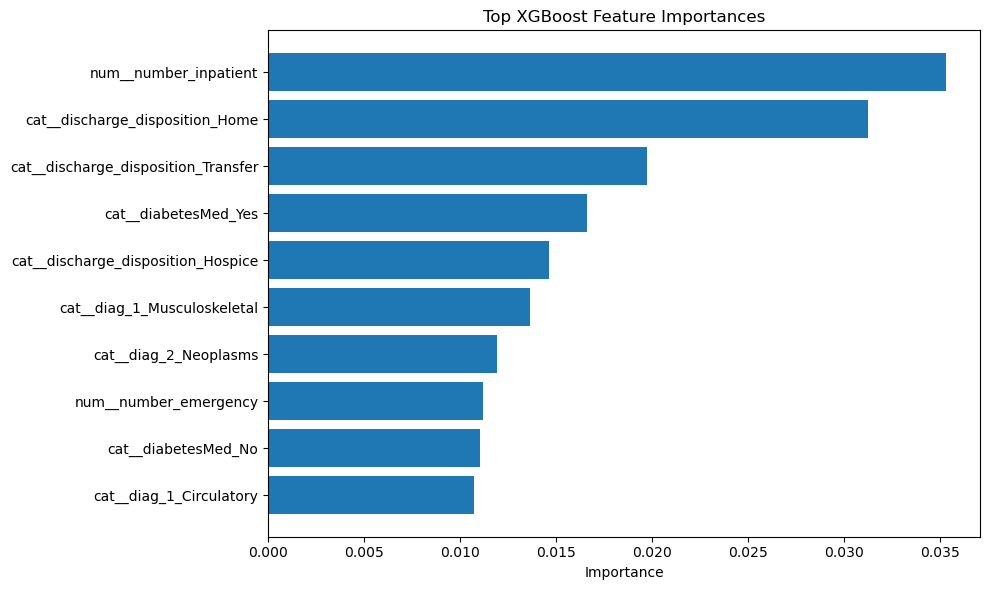

In [20]:
# View top features 
top_n = 10
print(feat_importances.head(top_n))

# Plot top features 
plt.figure(figsize=(10,6))
plt.barh(feat_importances.head(top_n)['Feature'][::-1],
         feat_importances.head(top_n)['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top XGBoost Feature Importances')
plt.tight_layout()
plt.show()

#### 📌 Key Insights

- Prior utilization is critical: The strongest feature (*num__number_inpatient*) shows that past behavior predicts future behavior—patients with more hospitalizations or ER visits tend to return.

- Discharge planning matters: Both “Home” and “Transfer” discharge dispositions rank highly, implying the type of follow-up care plays a major role.

- Chronic conditions drive risk: Diabetes, cancer (*neoplasms*), musculoskeletal, and circulatory diagnoses are recurrent themes—these align with clinical expectations for readmissions.

- Diabetes management is nuanced: Both *diabetesMed_Yes* and *diabetesMed_No* appearing in the top 10 suggests that whether or not a patient is on diabetes medication distinguishes different readmission risk profiles.

### Validate with SHAP values

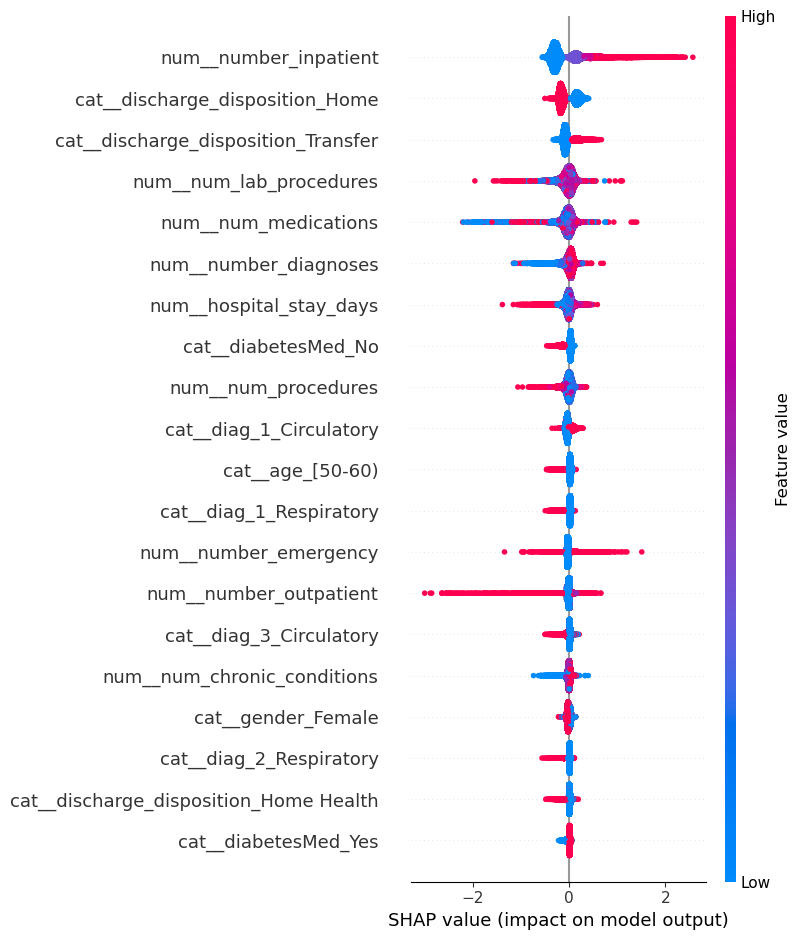

In [21]:
import shap

explainer = shap.TreeExplainer(fitted_model)
shap_values = explainer.shap_values(fitted_preprocessor.transform(X_train))

# Summary plot for global feature importance
shap.summary_plot(shap_values, features=fitted_preprocessor.transform(X_train), feature_names=feature_names)


#### 📌 Feature Insights

1. **num__number_inpatient**

- Many prior inpatient stays strongly increase readmission risk.


2. **cat__discharge_disposition_Home**

- Being discharged home (feature encoded as present) tends to increase readmission risk compared to other discharge types, likely indicating insufficient follow-up or outpatient support for some patients.

3. **cat__discharge_disposition_Transfer**

- Transfers to another facility show a positive SHAP influence, suggesting complex cases are more likely to return.

4. **num__num_lab_procedures** & **num__num_medications** 

- Higher numbers (red) lean slightly positive, meaning intensive lab testing or multiple medications may flag more severe conditions.

5. **num__hospital_stay_days** 

- Longer stays trend slightly positive, indicating more serious hospitalizations can lead to higher readmission risk.

6. **cat__diabetesMed_No** and **cat__diabetesMed_Yes**

- Not on diabetes meds (No) sometimes decreases risk, perhaps representing patients without severe diabetes.

- On meds (Yes) can increase risk, highlighting diabetes as a key chronic condition influencing outcomes.

7. **cat__diag_1_Circulatory** & **cat__diag_1_Respiratory**

- Cardiovascular and respiratory conditions tend to slightly elevate readmission risk, consistent with known chronic disease patterns.

8. **Age group [50-60]** 

- This bracket has a mild positive association, suggesting middle-aged adults in this range may have more complex conditions compared to younger or older groups.